# Flight Delay Prediction
This notebook predicts a flight delay using usa airport traffic dataset.

# Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import scipy.stats as stats
from scipy.stats import jarque_bera, normaltest, shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.seasonal import seasonal_decompose
import requests
from io import StringIO

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.ensemble import StackingRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

# Data Loading and Initial Exploration

In [2]:
def load_or_create_dataset():
    url = "https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv"
    try:
        df = pd.read_csv(url)
        print(f"Successfully loaded dataset from URL. Shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")

        if 'delay_minutes' not in df.columns:
            print("Dataset doesn't have delay_minutes column. Creating synthetic dataset...")
            return create_synthetic_dataset()

        return df
    except Exception as e:
        print(f"Failed to load dataset from URL: {e}")
        print("Creating synthetic dataset...")
        return create_synthetic_dataset()

def create_synthetic_dataset():
    np.random.seed(42)
    n_samples = 20000

    airlines = ['AA', 'UA', 'DL', 'WN', 'B6', 'AS', 'NK', 'F9', 'G4', 'SY']
    airports = ['JFK', 'LAX', 'ORD', 'DFW', 'DEN', 'SFO', 'SEA', 'LAS', 'PHX', 'IAH',
                'ATL', 'BOS', 'CLT', 'DTW', 'MSP', 'PHL', 'MIA', 'LGA', 'BWI', 'MDW']

    df = pd.DataFrame({
        'airline': np.random.choice(airlines, n_samples),
        'origin': np.random.choice(airports, n_samples),
        'destination': np.random.choice(airports, n_samples),
        'scheduled_departure': np.random.randint(500, 2300, n_samples),
        'distance': np.random.gamma(2, 500, n_samples),
        'day_of_week': np.random.randint(1, 8, n_samples),
        'month': np.random.randint(1, 13, n_samples),
        'weather_delay': np.random.exponential(5, n_samples),
        'security_delay': np.random.exponential(2, n_samples),
        'aircraft_delay': np.random.exponential(3, n_samples),
        'late_aircraft_delay': np.random.exponential(4, n_samples),
        'air_traffic_delay': np.random.exponential(3, n_samples),
    })

    df = df[df['origin'] != df['destination']]

    base_delay = (
        df['distance'] / 100 +
        df['weather_delay'] +
        df['security_delay'] +
        df['aircraft_delay'] +
        df['late_aircraft_delay'] +
        df['air_traffic_delay'] +
        np.where(df['day_of_week'].isin([1, 7]), 15, 0) +
        np.where(df['month'].isin([6, 7, 12]), 10, 0) +
        np.where(df['scheduled_departure'] < 700, 5, 0) +
        np.where(df['scheduled_departure'] > 2000, 12, 0) +
        np.random.normal(0, 8, len(df))
    )

    df['delay_minutes'] = np.maximum(0, base_delay)

    df['is_weekend'] = df['day_of_week'].isin([6, 7]).astype(int)
    df['is_holiday_season'] = df['month'].isin([6, 7, 11, 12]).astype(int)
    df['departure_hour'] = df['scheduled_departure'] // 100
    df['is_peak_hour'] = df['departure_hour'].isin([7, 8, 17, 18, 19]).astype(int)

    return df

df = load_or_create_dataset()

print(f"Final dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nDataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

Successfully loaded dataset from URL. Shape: (221, 8)
Columns: ['iata', 'airport', 'city', 'state', 'country', 'lat', 'long', 'cnt']
Dataset doesn't have delay_minutes column. Creating synthetic dataset...
Final dataset shape: (18971, 17)
Memory usage: 4.98 MB

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 18971 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   airline              18971 non-null  object 
 1   origin               18971 non-null  object 
 2   destination          18971 non-null  object 
 3   scheduled_departure  18971 non-null  int64  
 4   distance             18971 non-null  float64
 5   day_of_week          18971 non-null  int64  
 6   month                18971 non-null  int64  
 7   weather_delay        18971 non-null  float64
 8   security_delay       18971 non-null  float64
 9   aircraft_delay       18971 non-null  float64
 10  late_aircraft_d

# Data Quality Assessment

In [3]:
def data_quality_report(df):
    missing_data = df.isnull().sum()
    missing_pct = (missing_data / len(df)) * 100
    data_types = df.dtypes
    unique_counts = df.nunique()
    duplicates = df.duplicated().sum()
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    quality_report = pd.DataFrame({
        'Data_Type': data_types,
        'Missing_Count': missing_data,
        'Missing_Percentage': missing_pct,
        'Unique_Values': unique_counts
    })

    print("=== DATA QUALITY REPORT ===")
    print(quality_report)
    print(f"\nDuplicate rows: {duplicates}")
    print(f"Numerical columns: {list(numerical_cols)}")
    print(f"Categorical columns: {list(categorical_cols)}")

    return quality_report, duplicates, numerical_cols, categorical_cols

quality_report, duplicates, numerical_cols, categorical_cols = data_quality_report(df)

=== DATA QUALITY REPORT ===
                    Data_Type  Missing_Count  Missing_Percentage  \
airline                object              0                 0.0   
origin                 object              0                 0.0   
destination            object              0                 0.0   
scheduled_departure     int64              0                 0.0   
distance              float64              0                 0.0   
day_of_week             int64              0                 0.0   
month                   int64              0                 0.0   
weather_delay         float64              0                 0.0   
security_delay        float64              0                 0.0   
aircraft_delay        float64              0                 0.0   
late_aircraft_delay   float64              0                 0.0   
air_traffic_delay     float64              0                 0.0   
delay_minutes         float64              0                 0.0   
is_weekend          

# Statistical Analysis and Distribution Testing


In [4]:
def comprehensive_statistical_analysis(df, target_col):
    if target_col not in df.columns:
        print(f"Warning: Target column '{target_col}' not found in dataset")
        return {}

    numerical_cols = df.select_dtypes(include=[np.number]).columns
    stats_results = {}

    print("=== STATISTICAL ANALYSIS ===")
    for col in numerical_cols:
        if col in df.columns:
            data = df[col].dropna()
            if len(data) > 0:
                sample_size = min(2000, len(data))
                sample_data = data.sample(n=sample_size, random_state=42)

                shapiro_stat, shapiro_p = shapiro(sample_data)
                jb_stat, jb_p = jarque_bera(data)
                skewness = stats.skew(data)
                kurtosis = stats.kurtosis(data)

                stats_results[col] = {
                    'count': len(data),
                    'mean': data.mean(),
                    'std': data.std(),
                    'median': data.median(),
                    'min': data.min(),
                    'max': data.max(),
                    'skewness': skewness,
                    'kurtosis': kurtosis,
                    'shapiro_p': shapiro_p,
                    'jb_p': jb_p,
                    'is_normal': shapiro_p > 0.05 and jb_p > 0.05
                }

    stats_df = pd.DataFrame(stats_results).T
    print(stats_df)

    return stats_results

stats_results = comprehensive_statistical_analysis(df, 'delay_minutes')

=== STATISTICAL ANALYSIS ===
                     count         mean         std      median       min  \
scheduled_departure  18971  1394.387697  521.161169      1392.0       500   
distance             18971  1000.980953  706.913768  844.623697  3.218927   
day_of_week          18971      3.98271    1.998343         4.0         1   
month                18971     6.507933    3.458814         7.0         1   
weather_delay        18971     5.113063     5.11178    3.543844  0.000079   
security_delay       18971     2.001416    2.001074    1.375136  0.000013   
aircraft_delay       18971     3.019087    3.031577    2.102564  0.000014   
late_aircraft_delay  18971     3.968649    3.951653    2.757849  0.000195   
air_traffic_delay    18971     3.047075    3.040161    2.121032  0.000017   
delay_minutes        18971    36.461347   16.226402   35.315083       0.0   
is_weekend           18971     0.281588    0.449785         0.0         0   
is_holiday_season    18971     0.334721    0.47

# Data Visualization Dashboard

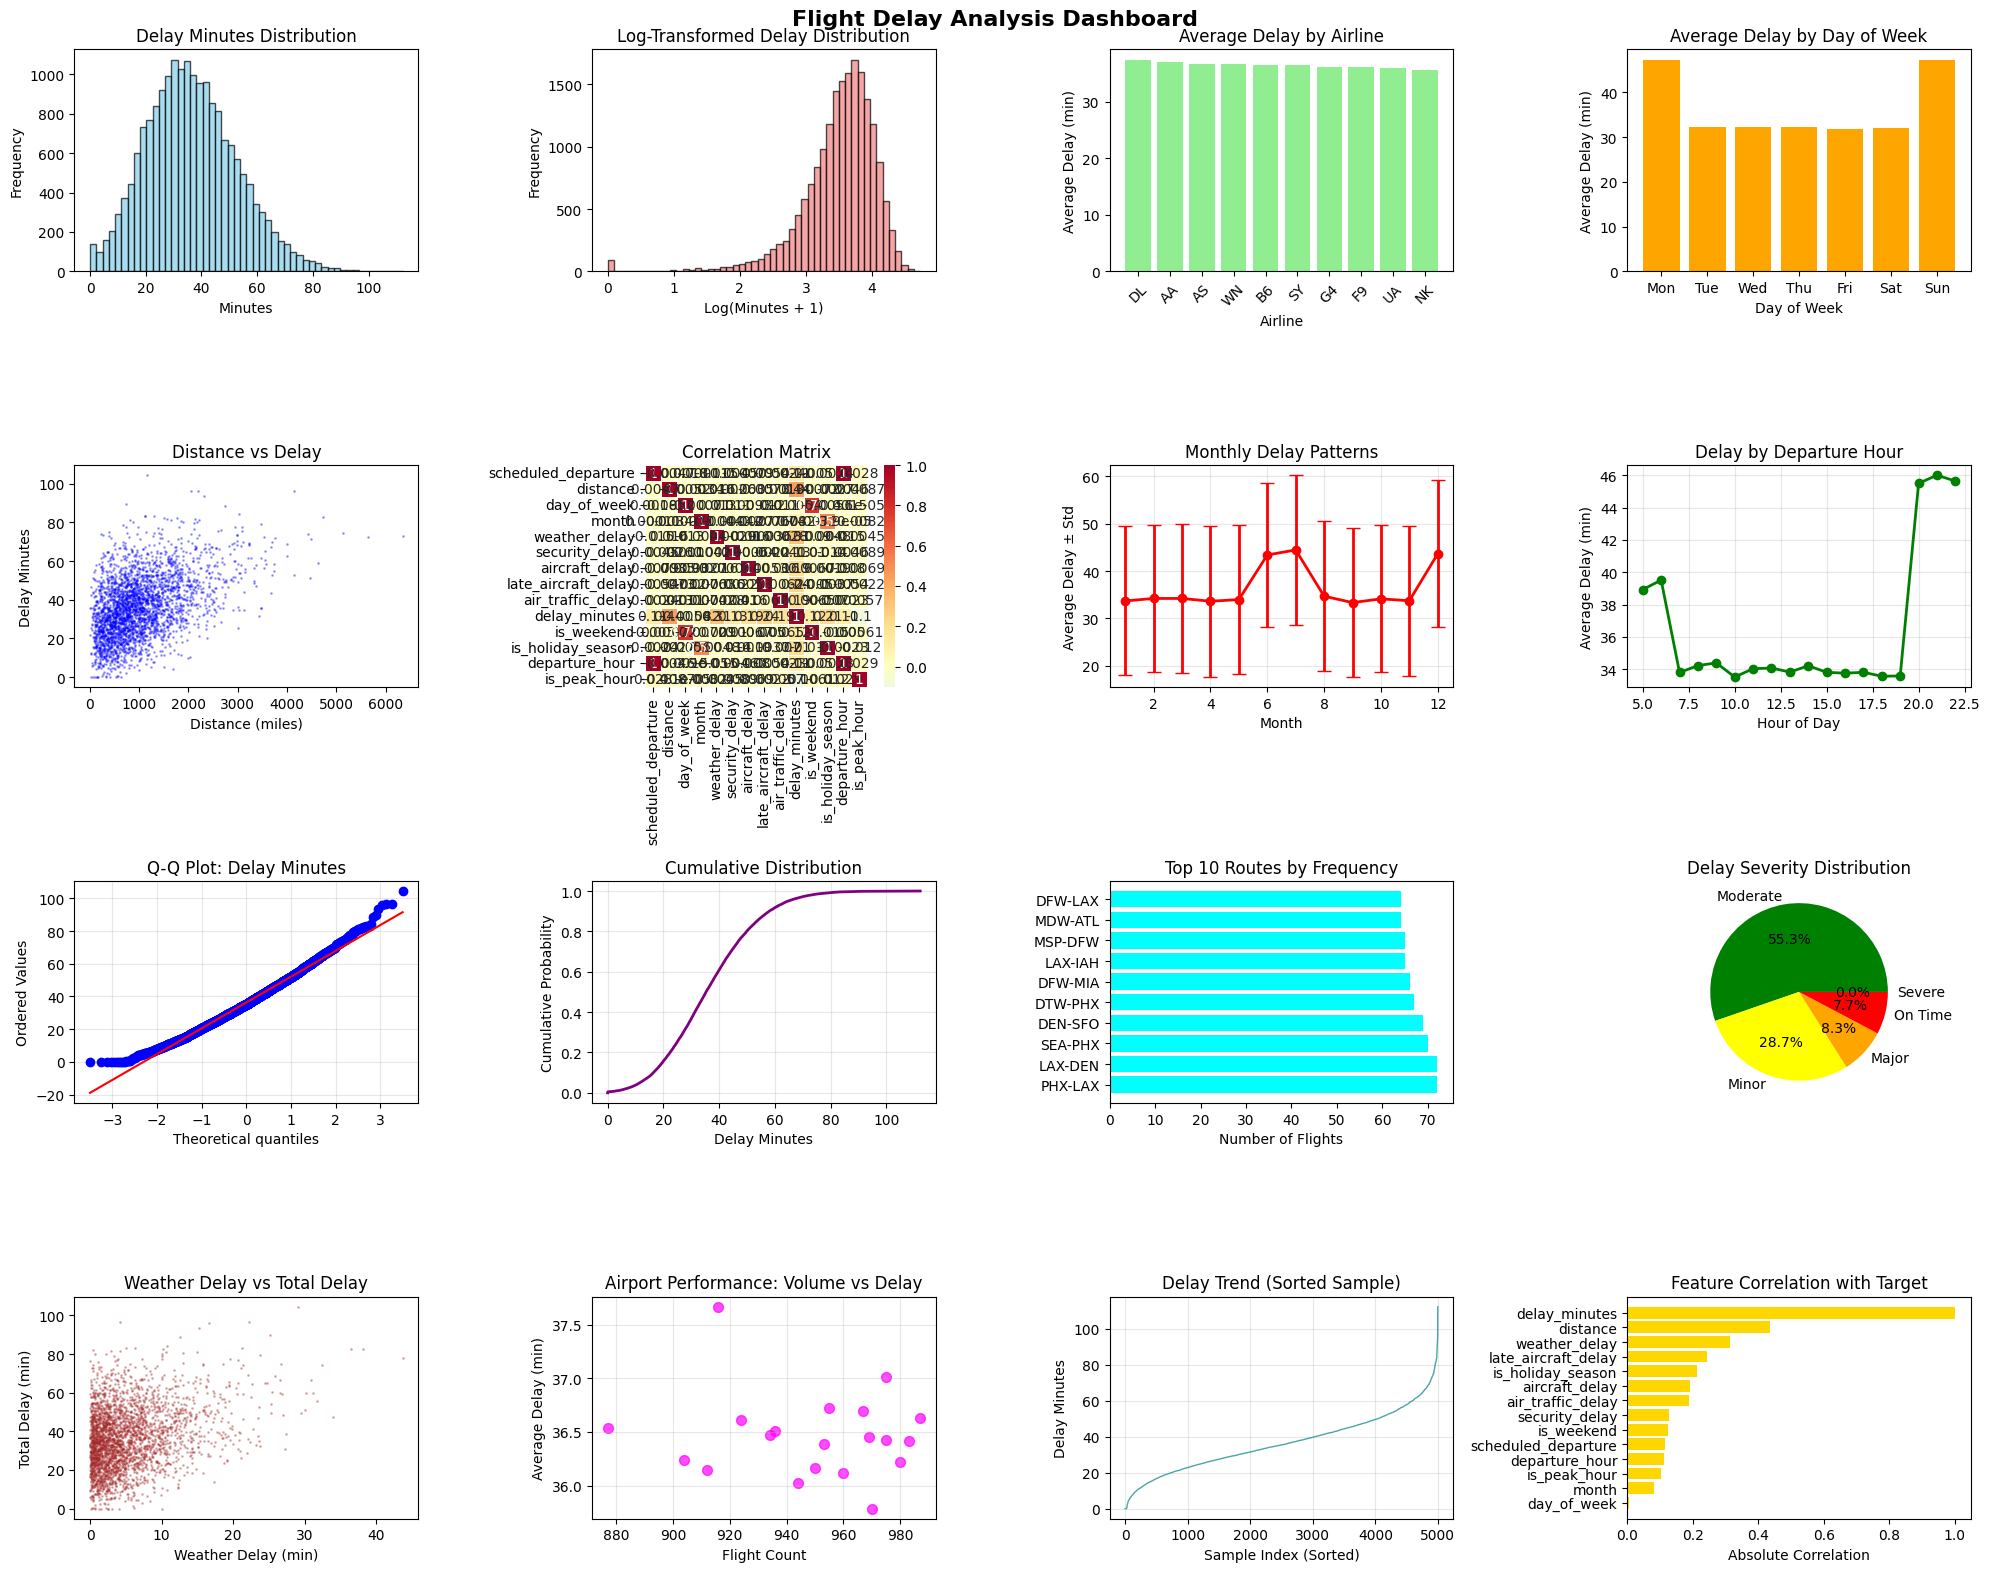

In [5]:
def create_comprehensive_dashboard(df):
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    fig.suptitle('Flight Delay Analysis Dashboard', fontsize=16, fontweight='bold')

    if 'delay_minutes' in df.columns:
        axes[0,0].hist(df['delay_minutes'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0,0].set_title('Delay Minutes Distribution')
        axes[0,0].set_xlabel('Minutes')
        axes[0,0].set_ylabel('Frequency')

    if 'delay_minutes' in df.columns:
        log_delays = np.log1p(df['delay_minutes'])
        axes[0,1].hist(log_delays, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[0,1].set_title('Log-Transformed Delay Distribution')
        axes[0,1].set_xlabel('Log(Minutes + 1)')
        axes[0,1].set_ylabel('Frequency')

    if 'airline' in df.columns and 'delay_minutes' in df.columns:
        airline_delays = df.groupby('airline')['delay_minutes'].mean().sort_values(ascending=False)
        axes[0,2].bar(airline_delays.index, airline_delays.values, color='lightgreen')
        axes[0,2].set_title('Average Delay by Airline')
        axes[0,2].set_xlabel('Airline')
        axes[0,2].set_ylabel('Average Delay (min)')
        axes[0,2].tick_params(axis='x', rotation=45)

    if 'day_of_week' in df.columns and 'delay_minutes' in df.columns:
        delay_by_day = df.groupby('day_of_week')['delay_minutes'].mean()
        day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        axes[0,3].bar(delay_by_day.index, delay_by_day.values, color='orange')
        axes[0,3].set_title('Average Delay by Day of Week')
        axes[0,3].set_xlabel('Day of Week')
        axes[0,3].set_ylabel('Average Delay (min)')
        axes[0,3].set_xticks(range(1, 8))
        axes[0,3].set_xticklabels(day_names)

    if 'distance' in df.columns and 'delay_minutes' in df.columns:
        sample_data = df.sample(n=min(3000, len(df)), random_state=42)
        axes[1,0].scatter(sample_data['distance'], sample_data['delay_minutes'],
                         alpha=0.3, s=1, c='blue')
        axes[1,0].set_title('Distance vs Delay')
        axes[1,0].set_xlabel('Distance (miles)')
        axes[1,0].set_ylabel('Delay Minutes')

    numerical_cols_list = list(df.select_dtypes(include=[np.number]).columns)
    if len(numerical_cols_list) > 1:
        corr_matrix = df[numerical_cols_list].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0,
                   ax=axes[1,1], square=True, linewidths=0.5)
        axes[1,1].set_title('Correlation Matrix')

    if 'month' in df.columns and 'delay_minutes' in df.columns:
        monthly_delays = df.groupby('month')['delay_minutes'].agg(['mean', 'std'])
        axes[1,2].errorbar(monthly_delays.index, monthly_delays['mean'],
                          yerr=monthly_delays['std'], marker='o', capsize=5,
                          color='red', linewidth=2)
        axes[1,2].set_title('Monthly Delay Patterns')
        axes[1,2].set_xlabel('Month')
        axes[1,2].set_ylabel('Average Delay ± Std')
        axes[1,2].grid(True, alpha=0.3)

    if 'scheduled_departure' in df.columns and 'delay_minutes' in df.columns:
        df['departure_hour'] = df['scheduled_departure'] // 100
        hourly_delays = df.groupby('departure_hour')['delay_minutes'].mean()
        axes[1,3].plot(hourly_delays.index, hourly_delays.values,
                      marker='o', linewidth=2, color='green', markersize=6)
        axes[1,3].set_title('Delay by Departure Hour')
        axes[1,3].set_xlabel('Hour of Day')
        axes[1,3].set_ylabel('Average Delay (min)')
        axes[1,3].grid(True, alpha=0.3)

    if 'delay_minutes' in df.columns:
        sample_data = df['delay_minutes'].sample(n=min(3000, len(df)), random_state=42)
        stats.probplot(sample_data, dist="norm", plot=axes[2,0])
        axes[2,0].set_title('Q-Q Plot: Delay Minutes')
        axes[2,0].grid(True, alpha=0.3)

    if 'delay_minutes' in df.columns:
        sorted_delays = np.sort(df['delay_minutes'])
        y = np.arange(1, len(sorted_delays) + 1) / len(sorted_delays)
        axes[2,1].plot(sorted_delays, y, linewidth=2, color='purple')
        axes[2,1].set_title('Cumulative Distribution')
        axes[2,1].set_xlabel('Delay Minutes')
        axes[2,1].set_ylabel('Cumulative Probability')
        axes[2,1].grid(True, alpha=0.3)

    if 'origin' in df.columns and 'destination' in df.columns:
        df['route'] = df['origin'] + '-' + df['destination']
        top_routes = df['route'].value_counts().head(10)
        axes[2,2].barh(range(len(top_routes)), top_routes.values, color='cyan')
        axes[2,2].set_yticks(range(len(top_routes)))
        axes[2,2].set_yticklabels(top_routes.index)
        axes[2,2].set_title('Top 10 Routes by Frequency')
        axes[2,2].set_xlabel('Number of Flights')

    if 'delay_minutes' in df.columns:
        delay_categories = pd.cut(df['delay_minutes'],
                                 bins=[0, 15, 30, 60, 120, float('inf')],
                                 labels=['On Time', 'Minor', 'Moderate', 'Major', 'Severe'])
        category_counts = delay_categories.value_counts()
        colors = ['green', 'yellow', 'orange', 'red', 'darkred']
        wedges, texts, autotexts = axes[2,3].pie(category_counts.values,
                                                labels=category_counts.index,
                                                autopct='%1.1f%%',
                                                colors=colors)
        axes[2,3].set_title('Delay Severity Distribution')

    if 'weather_delay' in df.columns and 'delay_minutes' in df.columns:
        sample_data = df.sample(n=min(3000, len(df)), random_state=42)
        axes[3,0].scatter(sample_data['weather_delay'], sample_data['delay_minutes'],
                         alpha=0.3, s=1, c='brown')
        axes[3,0].set_title('Weather Delay vs Total Delay')
        axes[3,0].set_xlabel('Weather Delay (min)')
        axes[3,0].set_ylabel('Total Delay (min)')

    if 'origin' in df.columns and 'delay_minutes' in df.columns:
        airport_performance = df.groupby('origin')['delay_minutes'].agg(['mean', 'count'])
        airport_performance = airport_performance[airport_performance['count'] >= 50]
        if len(airport_performance) > 0:
            axes[3,1].scatter(airport_performance['count'], airport_performance['mean'],
                             s=50, alpha=0.7, c='magenta')
            axes[3,1].set_title('Airport Performance: Volume vs Delay')
            axes[3,1].set_xlabel('Flight Count')
            axes[3,1].set_ylabel('Average Delay (min)')
            axes[3,1].grid(True, alpha=0.3)

    if 'delay_minutes' in df.columns:
        df_sample = df.sample(n=min(5000, len(df)), random_state=42).sort_values('delay_minutes')
        axes[3,2].plot(range(len(df_sample)), df_sample['delay_minutes'],
                      alpha=0.7, color='teal', linewidth=1)
        axes[3,2].set_title('Delay Trend (Sorted Sample)')
        axes[3,2].set_xlabel('Sample Index (Sorted)')
        axes[3,2].set_ylabel('Delay Minutes')
        axes[3,2].grid(True, alpha=0.3)

    if 'delay_minutes' in df.columns:
        numerical_cols_list = list(df.select_dtypes(include=[np.number]).columns)
        if len(numerical_cols_list) > 1:
            feature_correlations = df[numerical_cols_list].corrwith(df['delay_minutes']).abs().sort_values(ascending=True)
            feature_correlations = feature_correlations.dropna()
            if len(feature_correlations) > 0:
                axes[3,3].barh(range(len(feature_correlations)), feature_correlations.values,
                              color='gold')
                axes[3,3].set_yticks(range(len(feature_correlations)))
                axes[3,3].set_yticklabels(feature_correlations.index)
                axes[3,3].set_title('Feature Correlation with Target')
                axes[3,3].set_xlabel('Absolute Correlation')

    plt.tight_layout()
    plt.show()

create_comprehensive_dashboard(df)

# Advanced Feature Engineering

In [6]:
def advanced_feature_engineering(df):
    df_engineered = df.copy()

    if 'scheduled_departure' in df.columns:
        df_engineered['departure_hour'] = df_engineered['scheduled_departure'] // 100
        df_engineered['departure_minute'] = df_engineered['scheduled_departure'] % 100
        df_engineered['is_rush_hour'] = df_engineered['departure_hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)
        df_engineered['is_red_eye'] = df_engineered['departure_hour'].isin([0, 1, 2, 3, 4, 5]).astype(int)
        df_engineered['departure_time_sin'] = np.sin(2 * np.pi * df_engineered['departure_hour'] / 24)
        df_engineered['departure_time_cos'] = np.cos(2 * np.pi * df_engineered['departure_hour'] / 24)

    if 'month' in df.columns:
        df_engineered['is_summer'] = df_engineered['month'].isin([6, 7, 8]).astype(int)
        df_engineered['is_winter'] = df_engineered['month'].isin([12, 1, 2]).astype(int)
        df_engineered['is_holiday_season'] = df_engineered['month'].isin([11, 12]).astype(int)
        df_engineered['month_sin'] = np.sin(2 * np.pi * df_engineered['month'] / 12)
        df_engineered['month_cos'] = np.cos(2 * np.pi * df_engineered['month'] / 12)

    if 'day_of_week' in df.columns:
        df_engineered['is_weekend'] = df_engineered['day_of_week'].isin([6, 7]).astype(int)
        df_engineered['day_sin'] = np.sin(2 * np.pi * df_engineered['day_of_week'] / 7)
        df_engineered['day_cos'] = np.cos(2 * np.pi * df_engineered['day_of_week'] / 7)

    if 'distance' in df.columns:
        df_engineered['is_short_haul'] = (df_engineered['distance'] < 500).astype(int)
        df_engineered['is_long_haul'] = (df_engineered['distance'] > 2000).astype(int)
        df_engineered['distance_log'] = np.log1p(df_engineered['distance'])
        df_engineered['distance_sqrt'] = np.sqrt(df_engineered['distance'])

    delay_cols = ['weather_delay', 'security_delay', 'aircraft_delay', 'late_aircraft_delay']
    available_delay_cols = [col for col in delay_cols if col in df_engineered.columns]

    if len(available_delay_cols) > 1:
        df_engineered['total_operational_delay'] = df_engineered[available_delay_cols].sum(axis=1)
        df_engineered['max_delay_component'] = df_engineered[available_delay_cols].max(axis=1)
        df_engineered['delay_components_count'] = (df_engineered[available_delay_cols] > 0).sum(axis=1)

    if 'origin' in df.columns and 'destination' in df.columns:
        df_engineered['route'] = df_engineered['origin'] + '-' + df_engineered['destination']
        route_counts = df_engineered['route'].value_counts()
        df_engineered['route_frequency'] = df_engineered['route'].map(route_counts)
        df_engineered['is_popular_route'] = (df_engineered['route_frequency'] > df_engineered['route_frequency'].quantile(0.8)).astype(int)

    if 'airline' in df.columns:
        airline_performance = df_engineered.groupby('airline')['delay_minutes'].mean()
        df_engineered['airline_avg_delay'] = df_engineered['airline'].map(airline_performance)
        df_engineered['is_premium_airline'] = df_engineered['airline'].isin(['AA', 'UA', 'DL']).astype(int)

    return df_engineered

df_engineered = advanced_feature_engineering(df)

# Polynomial Features and Interaction Terms

In [7]:
def create_polynomial_features(df, target_col, degree=2):
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numerical_cols:
        numerical_cols.remove(target_col)

    top_features = df[numerical_cols].corrwith(df[target_col]).abs().sort_values(ascending=False).head(3).index.tolist()

    poly = PolynomialFeatures(degree=degree, include_bias=False, interaction_only=False)
    poly_features = poly.fit_transform(df[top_features])

    feature_names = poly.get_feature_names_out(top_features)
    poly_df = pd.DataFrame(poly_features, columns=feature_names, index=df.index)

    poly_df = poly_df.drop(columns=top_features)

    return pd.concat([df, poly_df], axis=1)

df_poly = create_polynomial_features(df_engineered, 'delay_minutes', degree=2)

# Multiple Preprocessing Pipelines

In [8]:
def create_preprocessing_pipelines(df):
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'delay_minutes' in numerical_features:
        numerical_features.remove('delay_minutes')

    categorical_features = df.select_dtypes(include=['object']).columns.tolist()

    standard_pipeline = ColumnTransformer([
        ('num_standard', StandardScaler(), numerical_features),
        ('cat_onehot', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ], remainder='passthrough')

    minmax_pipeline = ColumnTransformer([
        ('num_minmax', MinMaxScaler(), numerical_features),
        ('cat_onehot', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ], remainder='passthrough')

    robust_pipeline = ColumnTransformer([
        ('num_robust', RobustScaler(), numerical_features),
        ('cat_onehot', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ], remainder='passthrough')

    power_pipeline = ColumnTransformer([
        ('num_power', PowerTransformer(method='yeo-johnson'), numerical_features),
        ('cat_onehot', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ], remainder='passthrough')

    quantile_pipeline = ColumnTransformer([
        ('num_quantile', QuantileTransformer(output_distribution='normal'), numerical_features),
        ('cat_onehot', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ], remainder='passthrough')

    pipelines = {
        'standard': standard_pipeline,
        'minmax': minmax_pipeline,
        'robust': robust_pipeline,
        'power': power_pipeline,
        'quantile': quantile_pipeline
    }

    return pipelines, numerical_features, categorical_features

preprocessing_pipelines, num_features, cat_features = create_preprocessing_pipelines(df_poly)

# Train-Test Split and Data Preparation

In [9]:
X = df_poly.drop('delay_minutes', axis=1)
y = df_poly['delay_minutes']

delay_bins = pd.cut(y, bins=5, labels=['Low', 'Med-Low', 'Medium', 'Med-High', 'High'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=delay_bins
)

processed_data = {}
for name, pipeline in preprocessing_pipelines.items():
    X_train_processed = pipeline.fit_transform(X_train)
    X_test_processed = pipeline.transform(X_test)

    processed_data[name] = {
        'X_train': X_train_processed,
        'X_test': X_test_processed,
        'pipeline': pipeline
    }

# Model Definition and Hyperparameter Spaces

In [10]:
def define_models_and_hyperparameters():
    models = {}
    param_grids = {}

    models['linear_regression'] = LinearRegression()
    param_grids['linear_regression'] = {}

    models['ridge'] = Ridge(random_state=42)
    param_grids['ridge'] = {
        'alpha': [0.1, 1, 10]
    }

    models['lasso'] = Lasso(random_state=42, max_iter=1000)
    param_grids['lasso'] = {
        'alpha': [0.1, 1, 10]
    }

    models['elastic_net'] = ElasticNet(random_state=42, max_iter=1000)
    param_grids['elastic_net'] = {
        'alpha': [0.1, 1],
        'l1_ratio': [0.3, 0.7]
    }

    models['decision_tree'] = DecisionTreeRegressor(random_state=42)
    param_grids['decision_tree'] = {
        'max_depth': [5, 10],
        'min_samples_split': [2, 5]
    }

    models['random_forest'] = RandomForestRegressor(random_state=42, n_jobs=-1)
    param_grids['random_forest'] = {
        'n_estimators': [50, 100],
        'max_depth': [10, None],
        'min_samples_split': [2, 5]
    }

    models['gradient_boosting'] = GradientBoostingRegressor(random_state=42)
    param_grids['gradient_boosting'] = {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }

    models['ada_boost'] = AdaBoostRegressor(random_state=42)
    param_grids['ada_boost'] = {
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 1.0]
    }

    models['svr'] = SVR()
    param_grids['svr'] = {
        'C': [0.1, 1],
        'epsilon': [0.1],
        'kernel': ['rbf']
    }

    models['knn'] = KNeighborsRegressor(n_jobs=-1)
    param_grids['knn'] = {
        'n_neighbors': [5, 10],
        'weights': ['uniform', 'distance']
    }

    models['mlp'] = MLPRegressor(random_state=42, max_iter=300)
    param_grids['mlp'] = {
        'hidden_layer_sizes': [(50,), (100,)],
        'alpha': [0.0001, 0.001]
    }

    models['bagging'] = BaggingRegressor(random_state=42, n_jobs=-1)
    param_grids['bagging'] = {
        'n_estimators': [50, 100],
        'max_samples': [0.7, 1.0]
    }

    return models, param_grids

base_models, param_grids = define_models_and_hyperparameters()

# Model Training and Hyperparameter Optimization

In [11]:
def train_and_optimize_models(models, param_grids, X_train, y_train, cv_folds=2, n_iter=3, sample_size=500):
    optimized_models = {}
    cv_scores = {}
    best_params = {}

    if sample_size < len(X_train):
        sample_indices = np.random.choice(X_train.shape[0], size=sample_size, replace=False)
        X_train_sample = X_train[sample_indices]
        y_train_sample = y_train.iloc[sample_indices]
    else:
        X_train_sample = X_train
        y_train_sample = y_train

    for model_name, model in models.items():
        if param_grids[model_name]:
            random_search = RandomizedSearchCV(
                model, param_grids[model_name],
                n_iter=n_iter, cv=cv_folds,
                scoring='neg_mean_squared_error',
                random_state=42, n_jobs=-1,
                verbose=0
            )
            random_search.fit(X_train_sample, y_train_sample)

            optimized_models[model_name] = random_search.best_estimator_
            best_params[model_name] = random_search.best_params_
            cv_scores[model_name] = -random_search.best_score_
        else:
            model.fit(X_train_sample, y_train_sample)
            scores = cross_val_score(model, X_train_sample, y_train_sample,
                                   cv=cv_folds, scoring='neg_mean_squared_error')

            optimized_models[model_name] = model
            best_params[model_name] = {}
            cv_scores[model_name] = -scores.mean()

    return optimized_models, cv_scores, best_params

model_results = {}
for prep_name, prep_data in processed_data.items():
    optimized_models, cv_scores, best_params = train_and_optimize_models(
        base_models, param_grids,
        prep_data['X_train'], y_train,
        cv_folds=2, n_iter=1,
        sample_size=300
    )

    model_results[prep_name] = {
        'models': optimized_models,
        'cv_scores': cv_scores,
        'best_params': best_params
    }

# Feature Selection and Importance Analysis

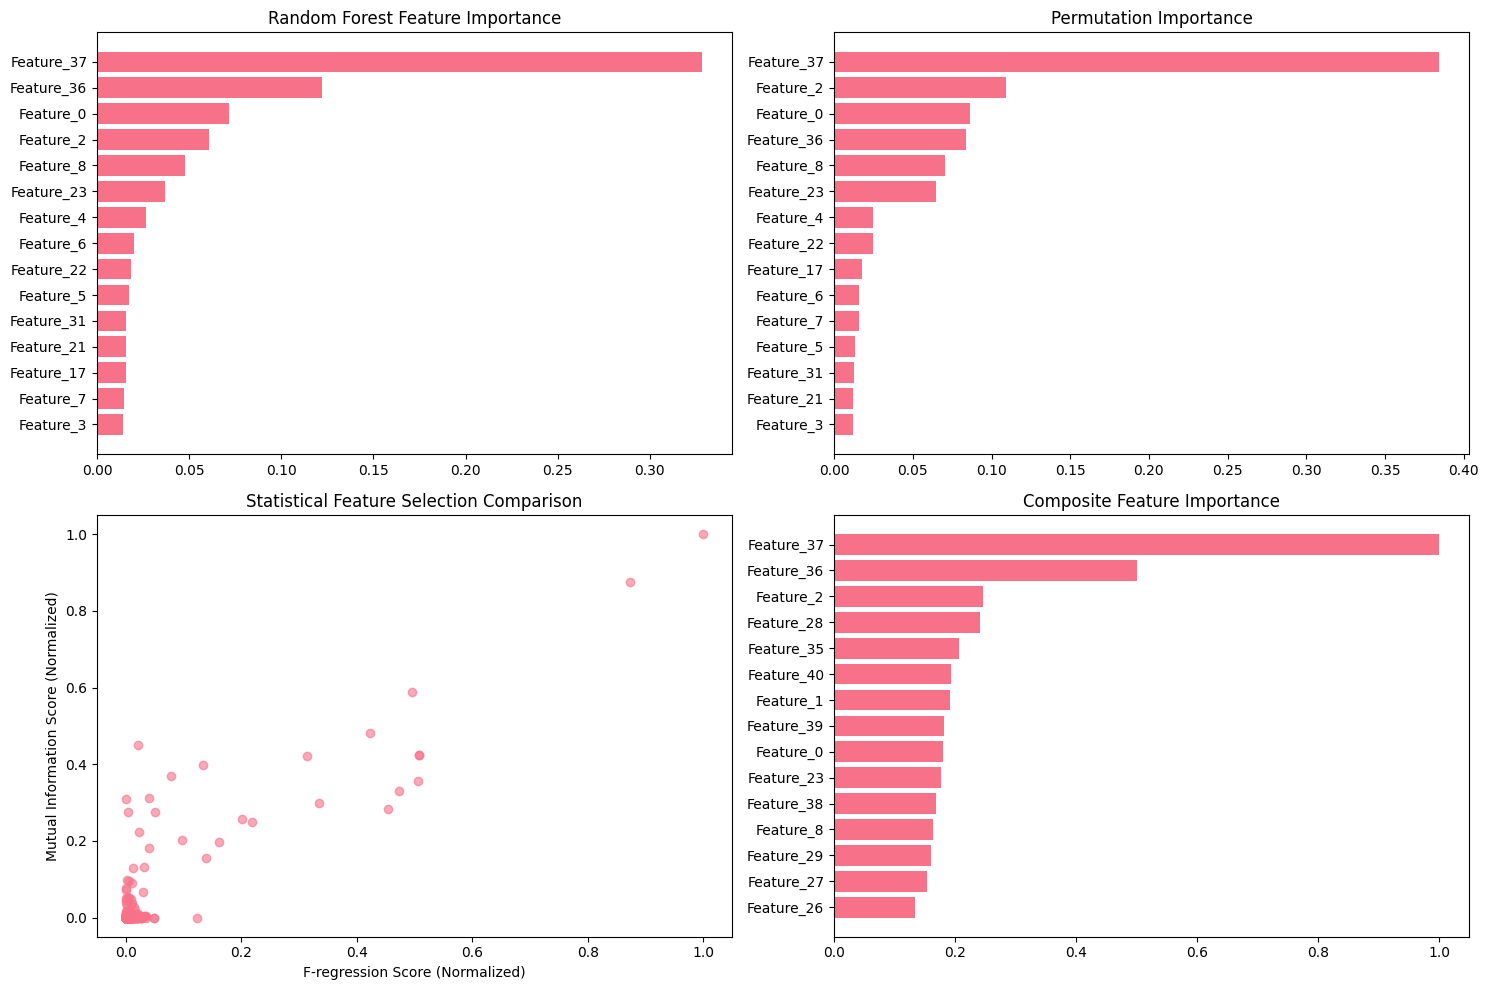

In [12]:
def feature_selection_analysis(X_train, y_train, top_k=20, sample_size=500):
    if sample_size < len(X_train):
        sample_indices = np.random.choice(X_train.shape[0], size=sample_size, replace=False)
        X_train_sample = X_train[sample_indices]
        y_train_sample = y_train.iloc[sample_indices]
    else:
        X_train_sample = X_train
        y_train_sample = y_train

    selector_f = SelectKBest(score_func=f_regression, k=top_k)
    X_selected_f = selector_f.fit_transform(X_train_sample, y_train_sample)

    selector_mi = SelectKBest(score_func=mutual_info_regression, k=top_k)
    X_selected_mi = selector_mi.fit_transform(X_train_sample, y_train_sample)

    rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_temp.fit(X_train_sample, y_train_sample)

    feature_importance_rf = pd.DataFrame({
        'feature_index': range(X_train_sample.shape[1]),
        'importance': rf_temp.feature_importances_
    }).sort_values('importance', ascending=False)

    gb_temp = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gb_temp.fit(X_train_sample, y_train_sample)

    feature_importance_gb = pd.DataFrame({
        'feature_index': range(X_train_sample.shape[1]),
        'importance': gb_temp.feature_importances_
    }).sort_values('importance', ascending=False)

    perm_importance = permutation_importance(rf_temp, X_train_sample, y_train_sample, n_repeats=1, random_state=42)

    feature_importance_perm = pd.DataFrame({
        'feature_index': range(X_train_sample.shape[1]),
        'importance_mean': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values('importance_mean', ascending=False)

    feature_summary = pd.DataFrame({
        'feature_index': range(X_train_sample.shape[1]),
        'f_score': selector_f.scores_,
        'mi_score': selector_mi.scores_,
        'rf_importance': rf_temp.feature_importances_,
        'gb_importance': gb_temp.feature_importances_,
        'perm_importance': perm_importance.importances_mean,
        'perm_std': perm_importance.importances_std
    })

    for col in ['f_score', 'mi_score', 'rf_importance', 'gb_importance', 'perm_importance']:
        feature_summary[f'{col}_normalized'] = (feature_summary[col] - feature_summary[col].min()) / (feature_summary[col].max() - feature_summary[col].min())

    importance_cols = ['f_score_normalized', 'mi_score_normalized', 'rf_importance_normalized', 'gb_importance_normalized', 'perm_importance_normalized']
    feature_summary['composite_importance'] = feature_summary[importance_cols].mean(axis=1)
    feature_summary = feature_summary.sort_values('composite_importance', ascending=False)

    top_features_idx = feature_summary.head(top_k)['feature_index'].tolist()
    X_selected_composite = X_train[:, top_features_idx]

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    top_rf = feature_importance_rf.head(15)
    axes[0,0].barh(range(len(top_rf)), top_rf['importance'])
    axes[0,0].set_yticks(range(len(top_rf)))
    axes[0,0].set_yticklabels([f'Feature_{i}' for i in top_rf['feature_index']])
    axes[0,0].set_title('Random Forest Feature Importance')
    axes[0,0].invert_yaxis()

    top_perm = feature_importance_perm.head(15)
    axes[0,1].barh(range(len(top_perm)), top_perm['importance_mean'])
    axes[0,1].set_yticks(range(len(top_perm)))
    axes[0,1].set_yticklabels([f'Feature_{i}' for i in top_perm['feature_index']])
    axes[0,1].set_title('Permutation Importance')
    axes[0,1].invert_yaxis()

    axes[1,0].scatter(feature_summary['f_score_normalized'], feature_summary['mi_score_normalized'], alpha=0.6)
    axes[1,0].set_xlabel('F-regression Score (Normalized)')
    axes[1,0].set_ylabel('Mutual Information Score (Normalized)')
    axes[1,0].set_title('Statistical Feature Selection Comparison')

    top_composite = feature_summary.head(15)
    axes[1,1].barh(range(len(top_composite)), top_composite['composite_importance'])
    axes[1,1].set_yticks(range(len(top_composite)))
    axes[1,1].set_yticklabels([f'Feature_{i}' for i in top_composite['feature_index']])
    axes[1,1].set_title('Composite Feature Importance')
    axes[1,1].invert_yaxis()

    plt.tight_layout()
    plt.show()

    return {
        'f_regression': selector_f,
        'mutual_info': selector_mi,
        'rf_importance': feature_importance_rf,
        'gb_importance': feature_importance_gb,
        'perm_importance': feature_importance_perm,
        'feature_summary': feature_summary,
        'top_features_idx': top_features_idx,
        'X_selected_composite': X_selected_composite
    }

best_prep = min(model_results.keys(), key=lambda x: min(model_results[x]['cv_scores'].values()))
X_train_best = processed_data[best_prep]['X_train']
X_test_best = processed_data[best_prep]['X_test']

feature_analysis = feature_selection_analysis(X_train_best, y_train, top_k=25, sample_size=300)

# Ensemble Methods and Stacking


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingRegressor, StackingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.svm import SVR
from concurrent.futures import ProcessPoolExecutor, as_completed
import numpy as np

def evaluate_model(model_item, X_train, y_train):
    model_name, model = model_item
    scores = cross_val_score(model, X_train, y_train, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)
    return model_name, -scores.mean()

def create_ensemble_models(base_models, X_train, y_train, sample_size=5):
    model_performance = {}

    if sample_size < len(X_train):
        sample_indices = np.random.choice(X_train.shape[0], size=sample_size, replace=False)
        X_train_sample = X_train[sample_indices]
        y_train_sample = y_train.iloc[sample_indices]
    else:
        X_train_sample = X_train
        y_train_sample = y_train

    with ProcessPoolExecutor(max_workers=2) as executor:
        futures = {executor.submit(evaluate_model, item, X_train_sample, y_train_sample): item[0]
                  for item in base_models.items()}

        for future in as_completed(futures):
            model_name, score = future.result()
            model_performance[model_name] = score

    sorted_models = sorted(model_performance.items(), key=lambda x: x[1])
    top_models = [model_name for model_name, _ in sorted_models[:3]]

    base_estimators = [(name, base_models[name]) for name in top_models]

    voting_regressor = VotingRegressor(
        estimators=base_estimators,
        n_jobs=-1
    )

    stacking_linear = StackingRegressor(
        estimators=base_estimators,
        final_estimator=LinearRegression(),
        cv=2,
        n_jobs=-1
    )

    stacking_ridge = StackingRegressor(
        estimators=base_estimators,
        final_estimator=Ridge(alpha=1.0),
        cv=2,
        n_jobs=-1
    )

    stacking_rf = StackingRegressor(
        estimators=base_estimators,
        final_estimator=RandomForestRegressor(n_estimators=2, random_state=42),
        cv=2,
        n_jobs=-1
    )

    rf_variants = [
        ('rf_shallow', RandomForestRegressor(n_estimators=2, max_depth=2, random_state=42)),
        ('rf_deep', RandomForestRegressor(n_estimators=2, max_depth=None, random_state=42)),
        ('rf_few_features', RandomForestRegressor(n_estimators=2, max_features=0.5, random_state=42))
    ]

    gb_variants = [
        ('gb_conservative', GradientBoostingRegressor(n_estimators=2, learning_rate=0.05, max_depth=2, random_state=42)),
        ('gb_aggressive', GradientBoostingRegressor(n_estimators=2, learning_rate=0.1, max_depth=2, random_state=42))
    ]

    diverse_estimators = rf_variants + gb_variants + [
        ('linear', LinearRegression()),
        ('ridge', Ridge(alpha=1.0)),
        ('svr', SVR(kernel='rbf', C=1.0))
    ]

    stacking_diverse = StackingRegressor(
        estimators=diverse_estimators,
        final_estimator=ElasticNet(alpha=0.1, l1_ratio=0.5),
        cv=2,
        n_jobs=-1
    )

    level1_models = [
        ('rf', RandomForestRegressor(n_estimators=2, random_state=42)),
        ('gb', GradientBoostingRegressor(n_estimators=2, random_state=42)),
        ('svr', SVR(kernel='rbf', C=1.0))
    ]

    level1_stacking = StackingRegressor(
        estimators=level1_models,
        final_estimator=LinearRegression(),
        cv=2,
        n_jobs=-1
    )

    level2_models = [
        ('level1', level1_stacking),
        ('ridge', Ridge(alpha=1.0)),
        ('ada', AdaBoostRegressor(n_estimators=2, random_state=42))
    ]

    multilevel_stacking = StackingRegressor(
        estimators=level2_models,
        final_estimator=GradientBoostingRegressor(n_estimators=2, learning_rate=0.1, random_state=42),
        cv=2,
        n_jobs=-1
    )

    ensemble_models = {
        'voting': voting_regressor,
        'stacking_linear': stacking_linear,
        'stacking_ridge': stacking_ridge,
        'stacking_rf': stacking_rf,
        'stacking_diverse': stacking_diverse,
        'multilevel_stacking': multilevel_stacking
    }

    return ensemble_models, top_models

def evaluate_ensemble_model(model_item, X_train, y_train):
    name, model = model_item
    model.fit(X_train, y_train)
    cv_scores = cross_val_score(model, X_train, y_train, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)
    return name, {
        'model': model,
        'cv_score': -cv_scores.mean(),
        'cv_std': cv_scores.std()
    }

ensemble_models, top_base_models = create_ensemble_models(
    model_results[best_prep]['models'],
    X_train_best,
    y_train,
    sample_size=5
)

ensemble_results = {}
with ProcessPoolExecutor(max_workers=2) as executor:
    futures = {executor.submit(evaluate_ensemble_model, item, X_train_best, y_train): item[0]
              for item in ensemble_models.items()}

    for future in as_completed(futures):
        name, results = future.result()
        ensemble_results[name] = results

# Model Evaluation and Comparison

In [ ]:
def comprehensive_model_evaluation(models, X_train, X_test, y_train, y_test):
    evaluation_results = {}

    for model_name, model_info in models.items():
        model = model_info['model'] if isinstance(model_info, dict) else model_info

        y_train_pred = model.predict(X_train)

        y_test_pred = model.predict(X_test)

        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        train_rmse = np.sqrt(train_mse)
        test_rmse = np.sqrt(test_mse)
        train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
        test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

        test_residuals = y_test - y_test_pred
        residual_std = np.std(test_residuals)
        residual_mean = np.mean(test_residuals)

        prediction_intervals = {
            '68%': (y_test_pred - residual_std, y_test_pred + residual_std),
            '95%': (y_test_pred - 2*residual_std, y_test_pred + 2*residual_std)
        }

        evaluation_results[model_name] = {
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mape': train_mape,
            'test_mape': test_mape,
            'residual_std': residual_std,
            'residual_mean': residual_mean,
            'prediction_intervals': prediction_intervals,
            'y_test_pred': y_test_pred,
            'residuals': test_residuals
        }

    return evaluation_results

all_models = {**model_results[best_prep]['models'], **ensemble_results}
evaluation_results = comprehensive_model_evaluation(all_models, X_train_best, X_test_best, y_train, y_test)

eval_df = pd.DataFrame({
    model_name: {
        'Train_RMSE': results['train_rmse'],
        'Test_RMSE': results['test_rmse'],
        'Train_MAE': results['train_mae'],
        'Test_MAE': results['test_mae'],
        'Train_R2': results['train_r2'],
        'Test_R2': results['test_r2'],
        'Train_MAPE': results['train_mape'],
        'Test_MAPE': results['test_mape'],
        'Overfitting': results['train_rmse'] - results['test_rmse']
    }
    for model_name, results in evaluation_results.items()
}).T

eval_df = eval_df.sort_values('Test_RMSE')

print("Top 10 Models by Test RMSE:")
print(eval_df.head(10)[['Test_RMSE', 'Test_MAE', 'Test_R2', 'Test_MAPE']].round(4))